In [1]:
import pandas as pd
import re
import os
from os import path
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
from scipy import interpolate
import numpy as np
import pylab as py
from pykrige.ok import OrdinaryKriging
from pyproj import Transformer

In [2]:
df = pd.read_csv("Bogota_lluvia_diario.csv")
df.dtypes

Unnamed: 0      int64
Estacion        int64
Year            int64
Mes             int64
Dia             int64
Valor         float64
Latitud       float64
Longitud      float64
dtype: object

<ipython-input-3-ad738e4fb2a3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_d['x'] = cartesian[1]
<ipython-input-3-ad738e4fb2a3>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_d['y'] = cartesian[0]


,Estacion,Year,Mes,Dia,Valor,Latitud,Longitud,x,y
0,21190270,2019,11,4,2.9,4.031028,-74.311167,9.740531e+05,9.375066e+05
1,21201230,2019,11,4,0.0,4.701125,-74.070306,1.000799e+06,1.011603e+06
2,21201240,2019,11,4,0.0,4.481306,-74.126278,9.945874e+05,9.872950e+05
3,21201300,2019,11,4,0.0,4.394250,-74.132000,9.939517e+05,9.776683e+05
4,21201580,2019,11,4,3.1,4.446500,-74.154833,9.914179e+05,9.834464e+05
5,21202280,2019,11,4,0.0,4.684000,-74.129000,9.942869e+05,1.009709e+06
6,21205580,2019,11,4,1.0,4.598361,-74.061556,1.001770e+06,1.000239e+06
7,21205710,2019,11,4,0.0,4.669333,-74.102667,9.972086e+05,1.008087e+06
8,21206260,2019,11,4,5.2,4.798639,-74.049722,1.003082e+06,1.022386e+06
9,21206560,2019,11,4,0.0,4.661111,-74.134778,9.936457e+05,1.007178e+06


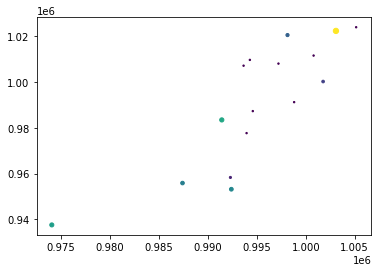

In [3]:
#Filtramos para la fecha deseada
year = 2019
mes =11
dia = 4
df_y = df[df['Year']== year]
df_m = df_y[df_y['Mes'] == mes]
df_d = df_m[df_m['Dia'] == dia]
#Cambiamos el sistema de coordenadas

#Primero, creamos la función que nos va a cambiar la proyección
proyectadas = Transformer.from_crs('EPSG:4326' , 'EPSG:3116')

#Segundo, Aplicamos la proyección

cartesian = proyectadas.transform(df_d['Latitud'].to_numpy(), df_d['Longitud'].to_numpy())
#Añadimos las nuevas columnas
df_d['x'] = cartesian[1]
df_d['y'] = cartesian[0]
plt.scatter(df_d.x, df_d.y, s = 2+df_d.Valor*5, c = df_d.Valor)
df_d = df_d.reset_index()
df_d = df_d.drop(['index','Unnamed: 0'] , axis=1)
df_d

In [4]:
min_y = df_d.y.min()
max_y = df_d.y.max()

min_x = df_d.x.min()
max_x = df_d.x.max()

grid_x = np.linspace(min_x, max_x, num = 60, endpoint= False)
grid_y = np.linspace(min_y, max_y, num = 60, endpoint= False)

#Creo que puedo reemplazar esto por un doble for
p_x,p_y = np.meshgrid(grid_x,grid_y)

In [5]:
#Ahora, para un punto x,y calculamos la diferencia de distancia con todos los puntos y seleccionamos las tres mas relevantes:

v_x = grid_x[0]
v_y = grid_y[0]
print(v_x, v_y)

974053.0730076038 937506.608804111


In [6]:
#Aqui calculamos explicitamente las distancias verticales y horizontales

def metodo_idw(v_x, v_y, dataframe):
    distancias = []
    for k in range(len(dataframe)):
        distancias.append( np.sqrt((dataframe.iloc[k]['x'] - v_x)**2 + (dataframe.iloc[k]['y'] - v_y)**2)  )

    data_idw = pd.DataFrame( distancias)
    data_idw['Lluvia'] = dataframe['Valor']
    data_idw.rename(columns = {0:'Distancia'}, inplace = True)

    by_distance = data_idw.sort_values(by ='Distancia')
    n = 0.0
    z = 0.0
    d = 0.0

    if by_distance.iloc[0]['Distancia'] != 0:
        for v in range(4):
            i_d =  1/(by_distance.iloc[v]['Distancia'])**2
            d += i_d
            n += by_distance.iloc[v]['Lluvia']/(by_distance.iloc[v]['Distancia'])**2
        z = n/d
    else:
        z = by_distance.iloc[0]['Lluvia']
    return z

In [7]:
metodo_idw(v_x, v_y, df_d)
#funciona

2.9

In [16]:
#Ahora finalmente aplicamos el método IDW para toda la malla de puntos
z_idw = []
for xx in np.nditer(grid_x):
    for yy in np.nditer(grid_y):
        z_idw.append(metodo_idw(xx,yy, df_d))


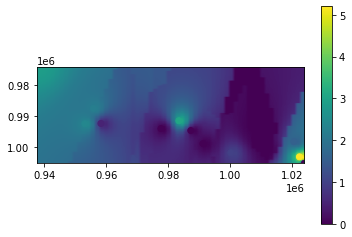

In [29]:
z_v = np.array(z_idw)
z_v =z_v.reshape((60,60))
plot(df_d['y'],df_d['x'],df_d['Valor'],z_v)

In [10]:
##INTERPOLACIÓN RBF

from scipy.interpolate import Rbf

In [11]:
xi, yi = p_x.flatten(), p_y.flatten()

In [12]:
interp = Rbf(df_d['x'], df_d['y'] , df_d['Valor'], function='linear')
grid1 = interp(xi, yi)
grid1 = grid1.reshape((60, 60))

In [27]:
def plot(x,y,z,grid):
    plt.figure()
    plt.imshow(grid, extent=(x.min(), x.max(), y.max(), y.min()))
    plt.scatter(x,y,c=z)
    plt.colorbar()

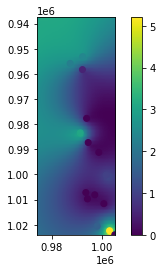

In [28]:
plot(df_d['x'],df_d['y'],df_d['Valor'],grid1)

In [23]:
valid = interp(9.923956e+05, 9.531196e+05)
valid

array(2.39998373)